In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -qq diffusers==0.12.1 datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.2 MB/s eta 0:00:00


In [ ]:
# Code to log in to the Hugging Face Hub, needed for sharing models
# Make sure you use a token with WRITE access
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# importing the "tarfile" module
import tarfile

file_name = "/content/drive/Shareddrives/Projects/be_project/singleImage.tar.gz"
# open file
file = tarfile.open(file_name)

# extracting file
file.extractall()
file.close()

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from dataclasses import dataclass

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [ ]:
@dataclass
class TrainingConfig:
    image_size = 256
    batch_size = 4
    pre_model = "google/ddpm-bedroom-256"
    num_epochs = 1
    gradient_accumulation_steps = 2
    lr = 1e-4
    lr_warmup_steps = 1000
    total_num_steps = 5000
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    model_dir = 'ddpm-clear-sat-256'

config = TrainingConfig()

In [ ]:
ds_path = "/content/singleImage/clear"

dataset = load_dataset(ds_path, split="train")

Resolving data files:   0%|          | 0/97640 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/clear-0d3456f01f8276fa/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [ ]:
dataset

Dataset({
    features: ['image'],
    num_rows: 97640
})

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

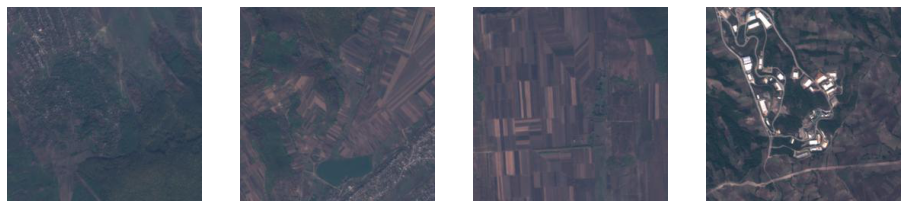

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
k = np.random.randint(0, 90000)
for i, image in enumerate(dataset[k:k+4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size = config.batch_size, shuffle=True
)

In [ ]:
from diffusers import DDIMScheduler, DDPMPipeline

In [ ]:
pipe = DDPMPipeline.from_pretrained(config.pre_model)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
pipe.config

FrozenDict([('unet', ('diffusers', 'UNet2DModel')),
            ('scheduler', ('diffusers', 'DDPMScheduler'))])

In [ ]:
pipe.scheduler.compatibles

[diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler]

In [ ]:
pipe.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.12.1')])

In [ ]:
scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.12.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [ ]:
scheduler.set_timesteps(num_inference_steps=100)

In [ ]:
scheduler.timesteps

tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])

In [ ]:
# pipe.to(device)

In [ ]:
from tqdm.auto import tqdm
import accelerate

In [ ]:
pipe.scheduler = scheduler

In [ ]:
pipe.unet.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

losses = []

optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=config.lr)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps= config.total_num_steps
)

In [ ]:
from accelerate import Accelerator

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps
    )
    
    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=config.total_num_steps, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch+1}")

        for step, batch in enumerate(train_dataloader):
            if step < config.total_num_steps:
                clean_images = batch['images']
                # Sample noise to add to the images
                noise = torch.randn(clean_images.shape).to(clean_images.device)
                bs = clean_images.shape[0]

                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

                # Add noise to the clean images according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
                
                with accelerator.accumulate(model):
                    # Predict the noise residual
                    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                    # Compare the prediction with the actual noise:
                    loss = F.mse_loss(noise_pred, noise) # trying to predict noise (eps)              
                    accelerator.backward(loss)
                    
                    if accelerator.sync_gradients: #when grad > 1
                        accelerator.clip_grad_norm_(model.parameters(), 1.0)
                    
                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()
                
                progress_bar.update(1)
                # Store for later plotting
                losses.append(loss.item())
                logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
                progress_bar.set_postfix(**logs)
                global_step += 1
            
            else:
              break

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                config.global_step = global_step
                pipe.save_pretrained(config.model_dir) 

In [ ]:
from accelerate import notebook_launcher

In [ ]:
args = (config, pipe.unet, pipe.scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args)

Launching training on one GPU.


  0%|          | 0/5000 [00:00<?, ?it/s]

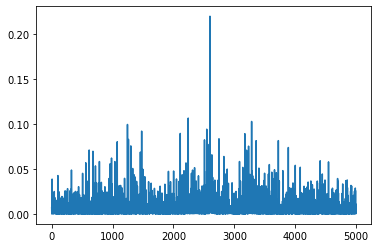

In [ ]:
# Plot the loss curve:
plt.plot(losses)

In [ ]:
print(f"average loss: {sum(losses[-config.total_num_steps:])/config.total_num_steps:.4f}")

average loss: 0.0057


In [ ]:
pipe.save_pretrained(config.model_dir) 

In [ ]:
!ls {config.model_dir}

model_index.json  scheduler  unet


In [ ]:
from huggingface_hub import HfApi, create_repo, get_full_repo_name

In [ ]:
# Code to upload a pipeline saved locally to the hub

# Set up repo and upload files
model_name = config.model_dir
local_folder_name = config.model_dir 
description = "unconditional ddpm model to generate satellite images (256x256)"
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

'https://huggingface.co/RavGau/ddpm-clear-sat-256/blob/main/model_index.json'

0it [00:00, ?it/s]

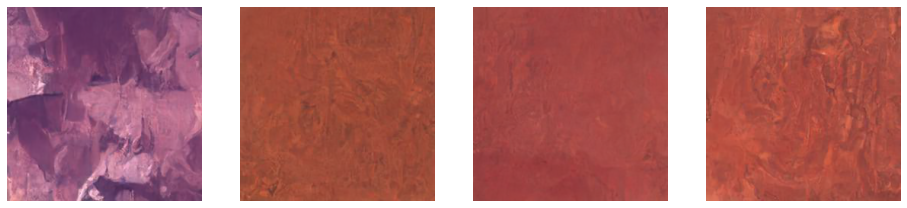

In [ ]:
#generate some sample images
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(x):
    axs[i].imshow(image.permute(1, 2, 0).cpu().numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

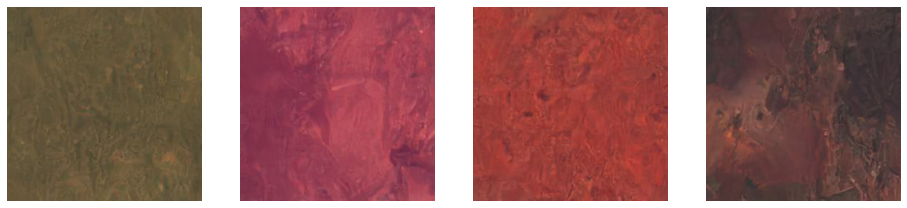

https://colab.research.google.com/drive/1wHih1TT6lxvBRLPnZWLLVLfanvNbUaGL?usp=sharing

In [ ]:
x.shape

torch.Size([4, 3, 256, 256])